In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
#from __future__ import print_function

## 2.2.2 Example: Bayesian A/B Testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A versus drug B. The company will test drug A on some percentage of a patient group, and drug B on the rest (this split is often 50-50, but we will relax this assumption). After performing enough trials, the in-house statisticians measure the effectiveness to determine which drug yielded results.

Similarly, front-end Web developers are interested in which design of their Web site yields more _conversions_, where a conversion could be a visitor signing up, purchasing something, or taking some other action. They will route some fraction of visitors to site A, and the other fraction to site B (which has an alternate design), and record if the visit yielded a conversion or not. The assignments and conversions are recorded and analyzed afterward.

The key value of A/B tests is that there is only a single difference between groups. Thus, any significant change in the metrics (like drug effectiveness or conversions) can be directly attributed to the difference.

Often, the post-experiment analysis is done using something called a "hypothesis test" ike a _difference of means test_ or _difference of proportions test_. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (although not necessarily _learned_ this technique). And if you were like me, you may have felt uncomfortable with their derivatoin. If so, good. The Bayesian approach to this problem is more natural.



## 2.2.3 A Simple Case

As this is a _hacker_ book, we'll continue with the web-development example. For the moment, we will focus on the analysis of site A first. Assume that there is some probability, $p_A$, that users who are shown site A eventually convert. This is the true effectiveness of site A. Currently, this quantity is unknown to us.

Suppose site A was shown to $N$ people, and $n$ people converted. One might conlcude hastily that $p_A = \frac{n}{N}$.
Unfortunately, the _observed frequency_ $\frac{n}{N}$ does not necessarily equal $p_A$; there is a difference between the _observed frequency_ and the _true frequency_ of an event. The true frequency can be interpreted as the probability of an event occurring, and this does not necessarily equal the observed frequency. For example, the true frequency of rolling a 1 on a six-sided die is $\frac{1}{6}$, but if we roll the dice six times we may not see a 1 show up at all (the observed frequency)! We must commonly determine the true frequency of events like:

* The fraction of users who make purchases
* The proportion of some characteristic in a population
* The percentage of Internet users with cats
* Or the probability that it will rain tomorrow

Unfortunately, noise and complexities hide the true frequency from us and we must _infer_ it from observed data. We use Bayesian statistics to infer probable values of the true frequency using an apprpriate prior and observed data. With respect to our conversion example, we are interested in using what we know, $N$ (the total visitors) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of conversion, might be.

To set up a Bayesian model, we need to assign prior distributions to our unknown quantities. _A priori_, what do you think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [2]:
import pymc as pm

# The parameters are bounds of the Uniform
p = pm.Uniform('p', lower=0, upper=1)

For this example, suppose $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from N trials, we will use a **Bernoulli distribution**. A Bernoulli distribution is a binary random variable (0 or 1 only), and as our observations are binary (not convert or convert), it is appropriate here. More formally, if 
$X \sim \mbox{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1-p$. 
Of course, in practice we do not know $p_A$, but we will use it here to simulate artificial data.

In [4]:
# set constants
p_true = 0.05 # remember, this is unknown in real life
N = 1500

# Sample N Bernoulli random variables from Ber(0.05)
# Each random variable has a 0.05 chance of being a 1
# This is the data-generation step

occurrences = pm.rbernoulli(p_true, N)

print occurrences
# Remeber: Python treats True == 1, and False == 0
print occurences.sum()

[False False False ..., False False False]
60


In [5]:
# Occurrences.mean() is equal to n/N

print "What is the observed frequency in Group A? %.4f " % occurences.mean()

What is the observed frequency in Group A? 0.0400 


In [6]:
# Include the observatoins, which are Bernoulli

obs = pm.Bernoulli("obs", p, value=occurrences, observed = True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 0.8 sec

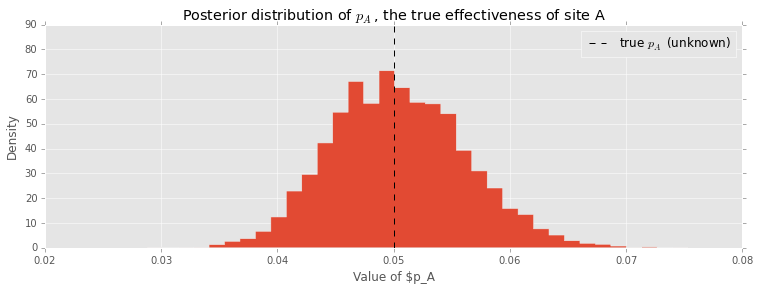

In [9]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plot

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--",
          label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=35, histtype="stepfilled", normed=True)
plt.xlabel("Value of $p_A")
plt.ylabel("Density")
plt.legend()

Our posterior distrubtion puts weight near what our data suggests is the true value of $p_A$: the higher the distribution, the more likely it is there. Try changing the number of observations, $N$, and observe how the posterior distribution changes.

In [10]:
apost = mcmc.trace("p")[:]

In [11]:
apost

array([ 0.05431838,  0.05431838,  0.05431838, ...,  0.05290064,
        0.05290064,  0.05290064])

In [12]:
apostseries = pd.Series(apost)

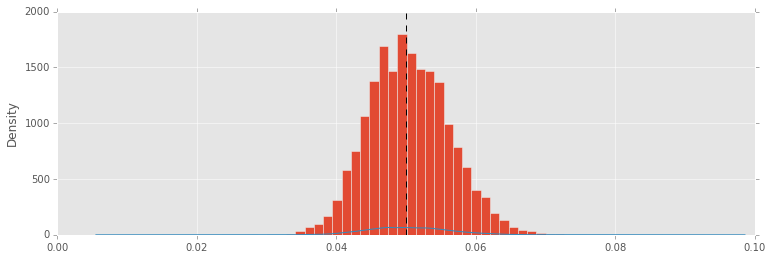

In [16]:
apostseries.plot(kind='hist',bins=35)
plt.vlines(p_true, 0, 2000, linestyle="--",
          label="true $p_A$ (unknown)")
apostseries.plot(kind='kde')

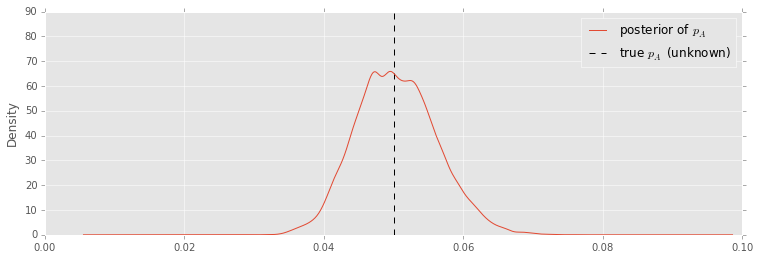

In [19]:
apostseries.plot(kind='kde', label="posterior of $p_A$")
plt.vlines(p_true, 0, 90, linestyle="--",
          label="true $p_A$ (unknown)")
plt.legend()

## 2.2.4 A and B Together

A similar analysis can be done for site B's response data to determine a posterior for $p_B$. What we are really interested in is the _difference_ between $p_A$ and $p_B$. Let's infer $p_A, p_B$, and delta = $p_A - p_B$, all at once.
We can do this using PyMC's deterministic variables. We'll assume for this exercise that $p_B = 0.04$ (though we don't know this), so delta = 0.01, $N_B = 750$ (only half of $N_A$) and we will simulate site B's data like we did for site A's data.

In [20]:
import pymc as pm
figsize(12,4)

# These two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# Notice the unequal sample sizes - no problem in Bayesian analysis
N_A = 1500
N_B = 750

# Generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print "Obs from Site A: ", observations_A[:30].astype(int), "..."
print "Obs from Site B: ", observations_B[:30].astype(int), "..."

Obs from Site A:  [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [21]:
print observations_A.mean()
print observations_B.mean()

0.052
0.0293333333333


In [22]:
# Set up the PyMC model. Again assume Uniform priors for p_A and p_B
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

# Define the deterministic delta function. This is our unknown of interest

@pm.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_A - p_B

# Set of observations; in this case, we hvae two observation datasets

obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# to be explained later
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 1.6 sec

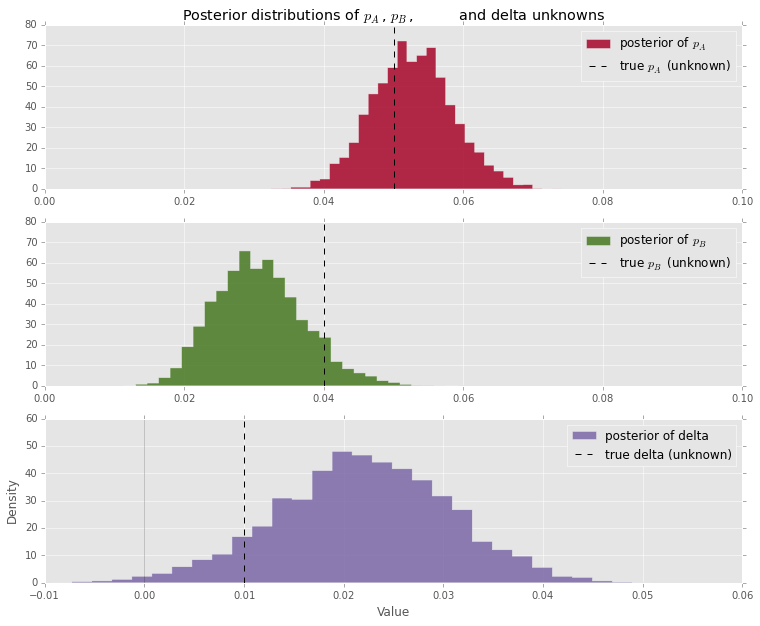

In [23]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

figsize(12.5, 10)

# histogram of posteriors 

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--",
           label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$,\
          and delta unknowns")
plt.ylim(0,80)

ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--",
           label="true $p_B$ (unknown)")
plt.legend(loc="upper right")
plt.ylim(0,80)

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(loc="upper right")

Notice that as a result of $N_B < N_A$ - that is, we have less data from site B - our posterior distribution for $p_B$ is fatter, implying we are less certain about the true value of $p_B$ than we are of $p_A$. This is easier to see if we plot thetwo posteriors on the same figure:

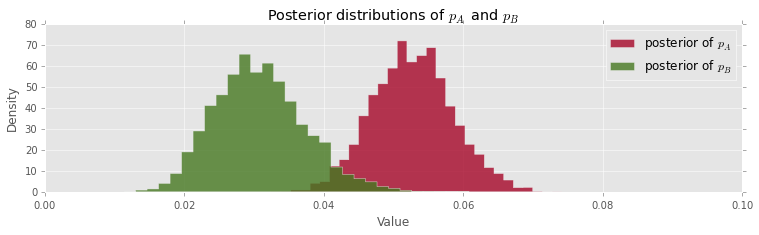

In [24]:
figsize(12.5, 3)

# histogram of posteriors 

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label="posterior of $p_A$", color="#A60628", normed=True)

plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.legend(loc="upper right")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior distributions of $p_A$ and $p_B$")
plt.ylim(0,80);

With respect to the posterior distribution of delta, we can see in Figure 2.2.6 that the majority of the distribution is above delta = 0, implying that site A’s response is likely better than site B’s response. The probability that this inference is incorrect is easily computable:

In [25]:
# Count the number of samples less than 0, i.e., the area under the curve 
# before 0, representing the probability that site A is worse than site B. 
print "Probability site A is WORSE than site B: %.3f " % \
    (delta_samples < 0).mean()

print "Probability site A is BETTER than site B: %.3f " % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.008 
Probability site A is BETTER than site B: 0.992 


In [26]:
df = pd.DataFrame({'$p_A$': p_A_samples,
                  '$p_B$': p_B_samples,
                  '$\Delta$': delta_samples})

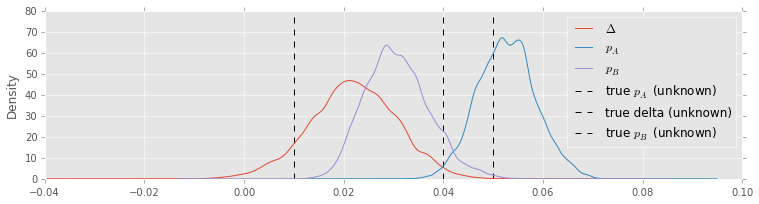

In [29]:
df.plot(kind='kde')
plt.vlines(true_p_A, 0, 80, linestyle="--",
           label="true $p_A$ (unknown)")
plt.vlines(true_p_A - true_p_B, 0, 80, linestyle="--",
           label="true delta (unknown)")
plt.vlines(true_p_B, 0, 80, linestyle="--",
           label="true $p_B$ (unknown)")
plt.legend()

can get the raw values of the kde from scipy:
http://stackoverflow.com/questions/24153278/how-to-get-output-of-pandas-plotkind-kde



If this probability is too high for cmopfortgable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A).

Try playing with the parameters ```true_p_A, true_p_B, N_A```, and ```N_B``` to see what the posterior of delta looks like. Notice that in all this, the difference in sample sizes between site A and site B was never mentioned; it naturally fits into Bayesian analysis.

I hope the readers feel that this style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practioners. In Chapter 5, we will see two extensions of this model: the first to help dynamically adjust for good sites, and the second to improve the speed of this computation by reducing the analysis to a single equation (Conjugate priors).

## 6.2 Subjective versus Objective Priors


Bayesian priors can be classified into two classes. The first are **objective priors**, which aim to allow the data to influence the posterior the most. The second class are **subjective priors**, which allow the practitioner to express his or views in the prior.

### 6.2.1 Objective Priors

What is an example of an objective prior? We have seen some already, including the **flat prior**, which is a uniform distribution over the entire range of the unknown. Using a flat prior implies that we give each possible value an equal weighting. Choosing this type of prior is invoking what is called the **Principle of Indifference**: We have no prior reason to favor one value over another. Calling a flat prior over a restricted space an objective prior is not correct, though it seems similar. If we know $p$ in a binomial model is greater than 0.5, then Uniform(0.5, 1) is not an objective prior (since we have used external knowledge) even though that distribution is indeed "flat" over [0.5, 1]. The flat prior must be flat over the entire range of possibilities, including 0 to 0.5.

Aside from the flat prior, other examples of objective priors are less obvious, but they contain important characteristics that reflect objectivity. For now, it should be said that rarely is an objective prior _truly_ objective. We will see this later.


### 6.2.2 Subjective Priors

On the other, if we add more probability mass to certain areas of the prior, and less elsewhere, we are biasing our inference toward the parameters existing in the areas with more probability mass. This is known as a subjective, or _informative_ prior.

In the figure below, the subjective prior describes a belief that the unknown likely lives around 0.5, and not around the extremes. The objective prior is insensitive to this.


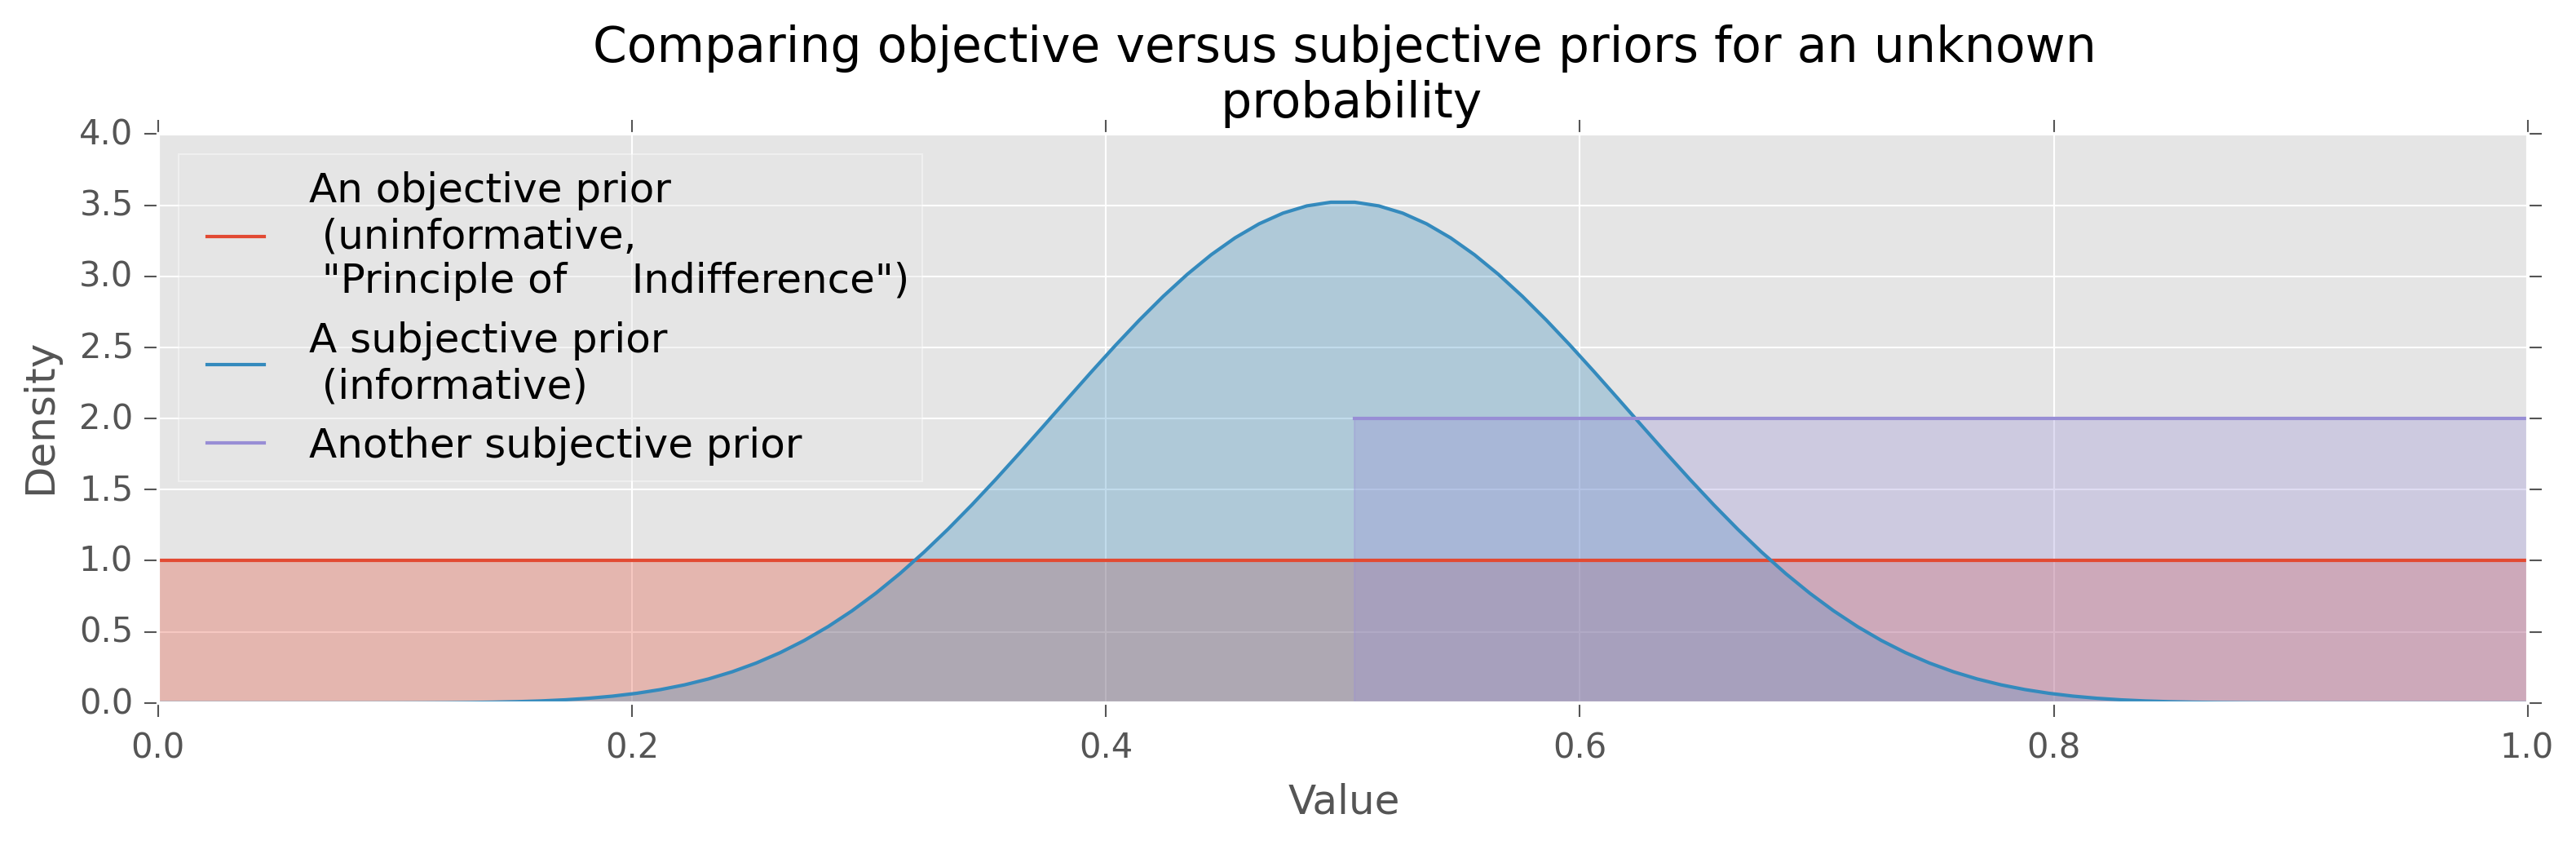

In [40]:
%matplotlib inline
import numpy as np 
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
import scipy.stats as stats 
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1,100)
y1, y2 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 10, 10)

p = plt.plot(x, y1,
    label='An objective prior \n (uninformative, \n "Principle of\
     Indifference")')
plt.fill_between(x, 0, y1, color=p[0].get_color(), alpha=0.3)


p = plt.plot(x, y2,
     label='A subjective prior \n (informative)')
plt.fill_between(x, 0, y2, color=p[0].get_color(), alpha=0.3)


p = plt.plot(x[50:], 2*np.ones(50), label="Another subjective prior")
plt.fill_between(x[50:], 0, 2, color=p[0].get_color(), alpha=0.3)


plt.ylim(0, 4)

plt.ylim(0, 4)
leg = plt.legend(loc="upper left")
leg.get_frame().set_alpha(0.4)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Comparing objective versus subjective priors for an unknown \n probability");

The choice of a subjective prior does not always imply that we are using the practitioner's subjective opinion; more often, the subjective prior was once a posterior to a previous problem, and now the practitioner is updating this posterior with new data. A subjective prior can also beused ot inject domain knowledge of the problem into the model. We will see examples of these two situations later.

### 6.2.3 Decisions, Decisions ...

The choice of an objective or subjective prior mostly depends on the problem being solved, but there are a few cases where one is preferred over the other. In instances of scientific research, the choice of an objective prior is obvious, as this eliminates any biases in the results. It should be the case that two researchers with differing beliefs about the topic of research still feel that an objective prior is "fair."

Consider a more extreme situation: Suppose a tobacco company publishes a report with a Bayesian methodology that challenges sixty years of medical research on tobacco use. Would you believe the results? Unlikley. The researchers probably chose a subjective prior that too strongly biased results in their favor.

Unfortunately, choosing an objective prior is not as simple as selecting a flat prior, and even today, the problem is still not completely solved. The problem with naively choosing the uniform prior is that pathological issues can arise. Some of these issues are pendantic, but we will later see an exmple of when this can be an issue.

WE must remember that choosing a pior, whether subjective or objective, is still part of the modeling process. To quote Gelman:

```
[A]fter the model has been fit, one should look at the posterior distribution and see if it makes sense. If the posterior distribution does not make sense, this implies that additional prior knowledge is available that has not been included in the model, and that contradicts the assumptions of the prior distribution that has been used. It is then appropriate to go back and alter the prior distribution to be more consistent with this external knowledge.
```

If the posterior does not make sense to you, then clearly you had an idea of what the posterior _should_ look like (not t be confused with what one _hopes_ it will look like), implying that the current prior does not contain all the prior information and should be updated. At this point, we can discard the current prior and choose one more reflective of _all_ our prior information.

Gelman[2] suggests that using a uniform distribution with large bounds is often a good choice for objective priors. However, one should be wary about using uniform objective priors with large bounds, as they can assign too large of a prior probability to points that are extremely unintuitive. Ask yourself: Do you really think the unknown could be incredibly large? Often, quantities are naturally biased toward 0. A Normal random variable with large variance (small precision) might be a better choice, or an exponential variable with a fat tail in the strictly positive (or negative) case.




## 6.3 Useful Priors to Know About

In the following, we'll go over some distributions that are common in Bayesian analysis and methods

### 6.3.1 The Gamma Distribution

A Gamma random variable, denoted $X \sim \mbox{Gamma}(\alpha, \beta)$ is a random variable over the positve real numbers. It is infact a generalization of the Exponential random variable, that is, 

$
\mbox{Exp}(\beta) \sim \mbox{Gamma}(1, \beta)
$

This additional parameter allows the probability density function to have more flexibility, hence allowing the practitioner to express his or her subjective priors more accurately. The density function for a Gamma($\alpha, \beta$) random variable is:

$
f(x | \alpha, \beta) = \frac{ \beta^{\alpha} x^{\alpha -1} e^{-\beta x}}{\Gamma(\alpha)}
$

where $\Gamma(\alpha)$ is the gamma function.

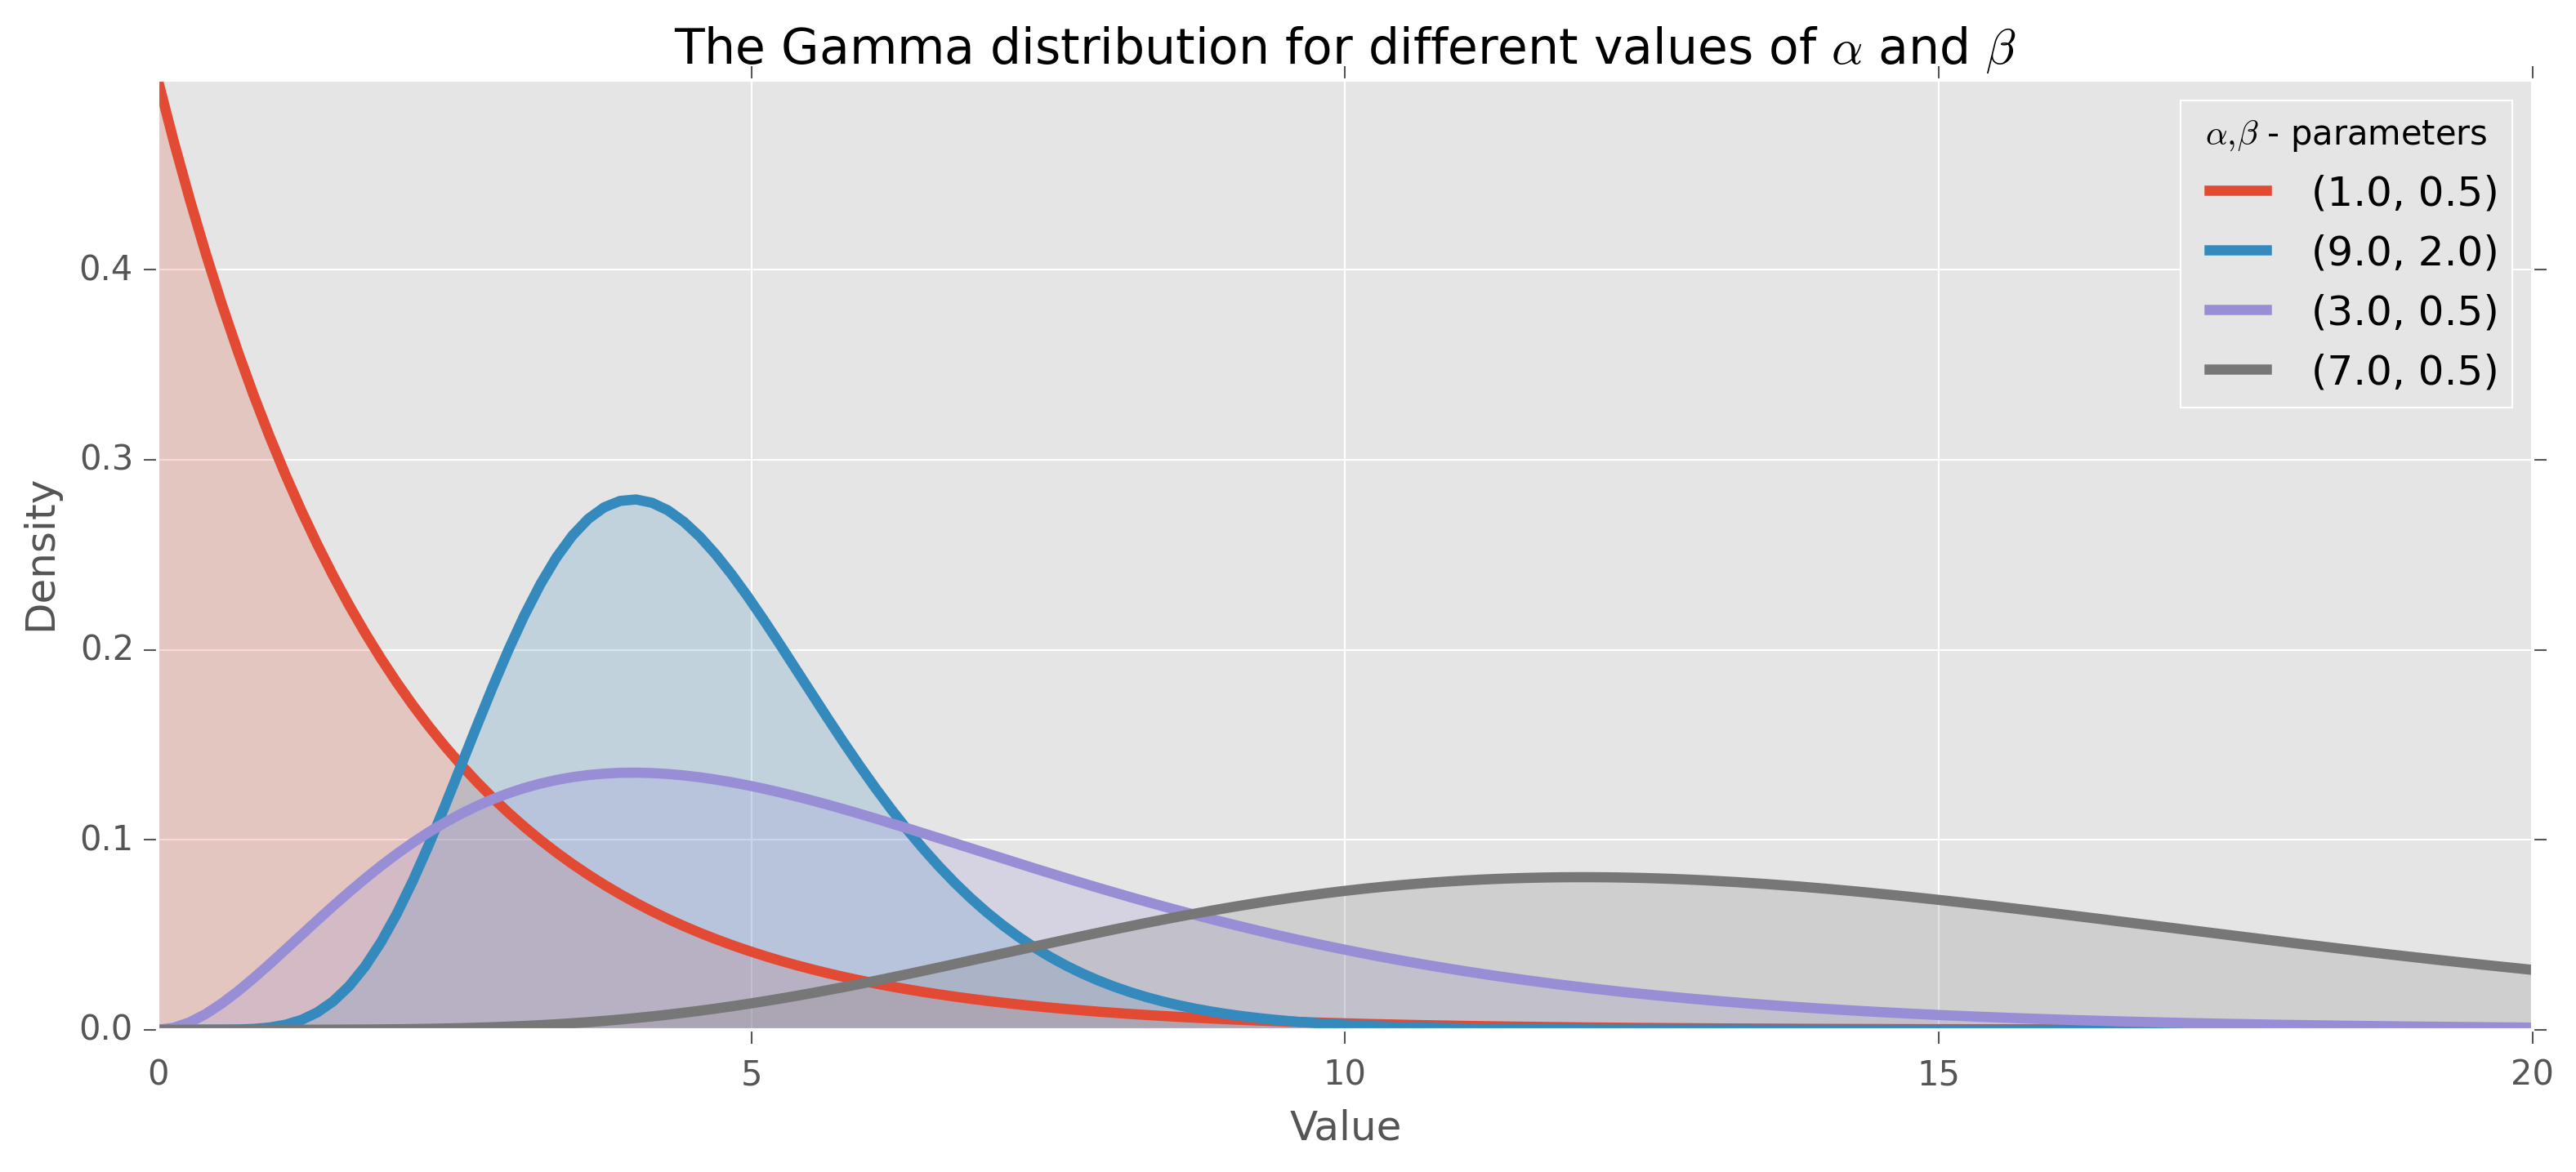

In [42]:
figsize(12.5, 5)
gamma = stats.gamma

parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]

x = np.linspace(0.001, 20, 150)

for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1./beta)
    lines = plt.plot(x, y, label="(%.1f, %.1f)" % (alpha, beta), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters")
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(r"The Gamma distribution for different values of $\alpha$ and $\beta$")